## Summary of Steps
#### Exploratory Visualization of Dataset
- Pandas + SeaBorn + MatPlotLib to create , load and append dataset from dataframe 
- Visualization to understand the distribution and quality of data
#### Data Collection based on Shortcomings
- Udacity Simulator and Udacity provided data to gather more data
- Based on the histogram distribution plots collecting data by using certain driving styles ( Lesser data with large steering angles , then drive more on curves)
- After initial model save and testing driving and training in problem areas to improve model on subset of data. 
#### Data Augmentation 
- Augmentation using Flipping, Translation from left and right camera images
- Reduce the time spent on data gathering through data augmentation techniques
#### Data Perturbation to Increase Model Robustness
- Brightness Perturbation, Gaussian Noise, Histogram Equalization, colospace inversion
- Increase the challenge and generalization capability by creating harder images for the model to train on. 
#### Define model architecture
- Data Pre-processing steps 
    - Normalization through feature scaling
    - Cropping region of interest
    - resize image to increase model performance
    - Batch Normalization before every activation
- Overfitting prevention 
    - Dropouts and batch norm 
- Use NVIDIA End to End Model architecture and train from scratch
#### Setup Model Training Pipeline
- Hyperparameters- Epochs , Steps per Epoch and Learning Rate decided based on search epochs on subset of data
- Greedy best save and checkpoint implementation.
- Metrics is a purely loss based model. Since the label here is numeric and non-categorical , RMS Loss is used as the loss type. 
#### Save and Deploy Model 
- Save using json, hdf5 model. 

### Import Necessary Modules

In [1]:
############ Data Processing #######################
import pandas as pd
import tarfile

########### Plotting Data and Visualization ##########
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

########## Arithmetic ######################
import numpy as np
import cv2
from skimage import filters
from skimage import exposure, img_as_ubyte
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter


################# Neural Network Model ##############
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D, Dropout, Cropping2D, ELU
from keras.layers.normalization import BatchNormalization
from keras.models import model_from_json, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import h5py


################### Other utilites ###################
import warnings
%matplotlib inline

Using TensorFlow backend.


### Helper Functions for Data Analysis and exploration
- ** DataFrame Populate ** : The csv file needs to be read and populated into a dataframe . 
- ** Compare Data ** - Plot two series against each other and visualize the variation of data with respect to Samples
- ** Distribution Plots** - Visualize the distribution of data across classes.

In [2]:
# Read the lines from the csv file and populate the Data Frame
def populate_dataframe(DriveLog):
    Data_ = pd.read_csv(DriveLog, header=None, names=[
                        'center_image', 'left_image', 'right_image', 'steer', 'Acc_ped', 'Brake'], index_col=False)
    Data_['steer'] = Data_['steer'].astype('float32')
    Data_['center_image'] = Data_['center_image'].astype('str')
    Data_['left_image'] = Data_['left_image'].astype('str')
    Data_['right_image'] = Data_['right_image'].astype('str')
    Data_['Sample_ID'] = range(len(Data_))
   
    ############# Populate sample IDs and filter data to populate left and right angles ###########
    Data_['Sample_ID'] = range(len(Data_))
    Data_['steer_filtered'] = savgol_filter(Data_['steer'], window_length=45, polyorder=4)
    Data_['steer_filtered']=Data_['steer_filtered'].apply(minmax_threshold)
    Data_['steer_left'] = (Data_['steer_filtered']+0.25).apply(minmax_threshold)
    Data_['steer_right'] = (Data_['steer_filtered']-0.25).apply(minmax_threshold)
    Data_['abs_steer'] = abs(Data_['steer_filtered']).apply(minmax_threshold)
    
    return Data_


def minmax_threshold(x):
    return min(max(x, -1),1)


def populate_dataframe_(DriveLog, ImagePath, isMac=True ):
    ###################### Change the image path to the cloud Jupyter Notebooks path ###################
    Data_ = pd.read_csv(DriveLog, header=None, names=[
                        'center_image', 'left_image', 'right_image', 'steer', 'Acc_ped', 'Brake'], index_col=False)
    
    if isMac:
        sep_char ='/'
    else:
        sep_char='\\'
    
    Data_['steer'] = Data_['steer'].astype('float32')
    Data_['center_image'] = Data_['center_image'].astype('str')
    Data_['center_image'] = ImagePath + Data_.center_image.str.split(sep_char).str[-1]
    Data_['left_image'] = Data_['left_image'].astype('str')
    Data_['left_image'] = ImagePath + Data_.left_image.str.split(sep_char).str[-1]
    Data_['right_image'] = Data_['right_image'].astype('str')
    Data_['right_image'] = ImagePath + Data_.right_image.str.split(sep_char).str[-1]

    ############## Create Steer angle Bins to Random Sample the Data ###############
    delta = 0.05
    steer = np.arange(0., 1.05, delta)
    group = np.arange(0, 21, 1)
    h_interp = interp1d(steer, group, kind='zero')

    ############# Populate sample IDs and filter data to populate left and right angles ###########
    Data_['Sample_ID'] = range(len(Data_))
    Data_['steer_filtered'] = Data_['steer']
    Data_['steer_left'] = (Data_['steer_filtered']+0.25)
    Data_['steer_right'] = (Data_['steer_filtered']-0.25)
    Data_['abs_steer'] = abs(Data_['steer_filtered'])
    Data_['group'] = h_interp(Data_['abs_steer'])
    
    return Data_

def set_plot_style():
    plt.figure(figsize=(20, 6))
    minimal_ = ["#e74c3c", "#34495e"]
    sns.set_context("notebook", font_scale=1.5,  rc={"lines.linewidth": 2.5})
    sns.set_palette(sns.color_palette(minimal_))
    sns.set_style("whitegrid")
    


############### Compare Data ###########################
def compare_data(path1_, path2_, title_, show_all=False):
    dataframe_1 = populate_dataframe(path1_[0])
    dataframe_2 = populate_dataframe(path2_[0])
    set_plot_style()
    plt.plot(dataframe_1.Sample_ID, dataframe_1.steer_filtered,
                 lw=2.5, label=str(path1_[2]) )
    plt.plot(dataframe_2.Sample_ID, dataframe_2.steer_filtered,
                 lw=2.5, label=str(path2_[2]))
    plt.title(title_)
    plt.legend()
    plt.show()
    
    if show_all:
        ######################## Left ########################################
        set_plot_style()
        plt.plot(dataframe_2.Sample_ID,
                 dataframe_2.steer_left, lw=2, label=path2_[2]+'left')
        plt.plot(dataframe_1.Sample_ID,
                 dataframe_1.steer_left, lw=2, label=path1_[2]+'left')
        plt.legend()
        plt.show()

        ################ Right #########################################
        set_plot_style()
        plt.plot(dataframe_2.Sample_ID,
                 dataframe_2.steer_right, lw=2, label=path2_[2]+'right')
        plt.plot(dataframe_1.Sample_ID,
                 dataframe_1.steer_right, lw=2, label=path1_[2]+'right')
        plt.legend()
        plt.show()

def get_path_data_dist(path_):
    dataframe = populate_dataframe(path_[0])
    set_plot_style()
    sns.distplot(np.concatenate((dataframe.steer_filtered,dataframe.steer_left,dataframe.steer_right)), axlabel=path_[2]+"Steering Angle Dist")

def get_df_data_dist(dataframe):
    set_plot_style()
    sns.distplot(np.concatenate((dataframe.steer_filtered,dataframe.steer_left,dataframe.steer_right)), axlabel="Steering Angle Dist")

def images_show(X_input, y, nr, nc, rand=True):
    
    X_disp = np.reshape(X_input, (X_input.shape[0], X_input.shape[1], X_input.shape[2], -1))
    if rand == True:
        X_disp, y = shuffle(X_disp, y)
    disp_im = X_disp[0:int(nr*nc)]
    plt.figure(figsize=(20,20))
    
    gs = gridspec.GridSpec(nr, nc, wspace=0.1, hspace=0.01)
    ax = [plt.subplot(gs[i]) for i in range(nr * nc)]
    for index, index_im in enumerate(disp_im):
        ax[index].imshow(index_im, cmap='gray')
        ax[index].axis('off')
        ax[index].set_title(y[index])
    plt.show()

### Exploratory Visualization of Dataset
- Visualizing collected data from driving the simulator shows that the dataset looks entirely different for **Keyboard** and **Mouse**.
- So we pass the data through a moving average filter that averages out the samples but maintains the Area = (*Steering_angle x Time*)
- This effectively filters out the noise without destroying the signal . 
- We will evaluate the performance of the model with filtered and unfiltered data. 

### Distribution of data
- As one can observe there is a strong skew of data on the Negative steering angle . 
- The issue can be resolved by simply driving in the anticlockwise direction . 

### Deep diving and looking into details 

### Clockwise Data  Distribution

- Clear Negative Skew where most of the turns are leftward on track 1
- Since track 1 is mostly navigable using low steering angles it has a very high mode around 0.

### Anticlockwise Steering Data Histogram

- Clear Negative skew as most of the turns are rightward
- Other observations are quite similar to what was made track 1 

### Combined Data 
- Data from Track 1 - Clock wise and anticlockwise (MAC & Windows)
- Data from Track 2 - Clock wise and anticlockwise (MAC & Windows)
- Smooth Turn from both Tracks (MAC & Windows)
- Recovery driving from both Tracks (MAC & Windows)
- Problem Areas in both tracks (MAC & Windows)
- Keyboard and Mouse 

In [3]:
################ Data Gathered in Mouse on Track 1 #############
drivelog_path1 = "./Track1/driving_log.csv"
images_path1 = "./Track1/IMG/"
path1 = [drivelog_path1, images_path1, 'MAC Track-1', True]


################ Data Gathered in Mouse on Track 1 #############
drivelog_path2 = "./Track1_2/driving_log.csv"
images_path2 = "./Track1_2/IMG/"
path2 = [drivelog_path2, images_path2, 'MAC Track-1 anticlockwise', True]


################ Data Gathered in Mouse on Track 1 #############
drivelog_path3 = "./Track2/driving_log.csv"
images_path3 = "./Track2/IMG/"
path3 = [drivelog_path3, images_path3, 'MAC Track-2', True]


################ Data Gathered in Mouse on Track 1 #############
drivelog_path4 = "./Track2_1/driving_log.csv"
images_path4 = "./Track2_1/IMG/"
path4 = [drivelog_path4, images_path4, 'MAC Track-2 anticlockwise', True]

################ Data Gathered in MAC  on Track 1 & 2 #############
drivelog_path5 = "./Mouse_track1_23052017_01/driving_log.csv"
images_path5 = "./Mouse_track1_23052017_01/IMG/"
path5 = [drivelog_path5, images_path5, 'Windows Track-1', False]

################ Data Gathered in MAC  on Track 1 & 2 #############
drivelog_path6 = "./Mouse_track1_23052017_02/driving_log.csv"
images_path6 = "./Mouse_track1_23052017_02/IMG/"
path6 = [drivelog_path6, images_path6, 'Windows Track-1 anticlockwise', False]

################ Data Gathered in MAC  on Track 1 & 2 #############
drivelog_path7 = "./Mouse_track2_23052017_03/driving_log.csv"
images_path7 = "./Mouse_track2_23052017_03/IMG/"
path7 = [drivelog_path7, images_path7, 'Windows Track-2 Clockwise', False]

################ Data Gathered in MAC  on Track 1 & 2 #############
drivelog_path8 = "./Mouse_track2_23052017_04/driving_log.csv"
images_path8 = "./Mouse_track2_23052017_04/IMG/"
path8 = [drivelog_path8, images_path8, 'Windows Track-2 anticlockwise', False]

################ Data Gathered in MAC  on Track 1 & 2 #############
drivelog_path9 = "./Recovery_Driving_01/driving_log.csv"
images_path9 = "./Recovery_Driving_01/IMG/"
path9 = [drivelog_path9, images_path9,
         'Keyboard & Mouse based recovery driving', False]


################ Data Gathered in MAC  on Track 1 & 2 #############
drivelog_path10 = "./data/driving_log.csv"
images_path10 = "./data/IMG/"
path10 = [drivelog_path10, images_path10, 'Udacitys data', True]


################ Data Gathered in MAC  on Track 1 & 2 #############
drivelog_path11 = "./Smooth_Turns/driving_log.csv"
images_path11 = "./Smooth_Turns/IMG/"
path11 = [drivelog_path11, images_path11, 'Smooth Turns Data', False]

### Comparisons 
- Verifying if filtration causes significant distortions in the signal in comparison to the original
- Keyboard Filtered vs Unfiltered
- Mouse vs Keyboard after filtration

In [ ]:
compare_data(path1,path2,"Clockwise vs Anti Clockwise")
compare_data(path2,path4, "Track 1 vs Track 2")
get_path_data_dist(path5)
get_path_data_dist(path10)

In [ ]:
###################### Load all paths and populate an entire dataframe ###
paths_ = [path1, path2, path3, path4, path5,
          path6, path7, path8, path9, path10, path11]
df_combined = [populate_dataframe_(
    path_[0], path_[1], path_[3]) for path_ in paths_]
complete_data = pd.concat(df_combined).reset_index(drop=True)
complete_data['Sample_ID'] = range(len(complete_data))
print("length of complete data : ", len(complete_data))


##### Get the counts of each group of data frame to allow a weighted rando
complete_data = complete_data.sort_values(['group'])
counts = complete_data.groupby(['group'], as_index=False).count()
table = interp1d(counts.group, counts.center_image)
complete_data['weights'] = 1. / table(complete_data['group'])
complete_data.to_csv('./Complete_Data.csv')
############### Plot the distribution of data ########################
get_df_data_dist(complete_data)

### Image Perturbation Techniques

In [7]:
################ Augmentation functions ##########################
def random_brightness(image):
    image_ = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    brightness_factor = .15 + np.random.uniform()
    image_[:, :, 2] = image_[:, :, 2] * brightness_factor
    image_ = cv2.cvtColor(image_, cv2.COLOR_HSV2RGB)
    return image_


def gaussian(image):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sigma_ = np.random.uniform(0.25, 1.)
        image_ = filters.gaussian(image, sigma=sigma_, multichannel=True)
        image_ = img_as_ubyte(image_, force_copy=True)
    return image_


def ahisteq(image):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        image_ = exposure.equalize_adapthist(image)
        image_ = img_as_ubyte(image_, force_copy=True)
    return image_

### Sampling Technique 
- Since the distribution is clearly tri modal (peaks around 0 for Center Camera , + 0.25 and -0.25 for left and right cameras respectievely ) it is an unbalanced dataset.
- Although significant efforts have been taken gather more data around turns , there is just simply more data around 0 and +/-0.25 
- Best possible option is to do Balancing through **DownSampling**
- The method used to do downsampling is **Weighted Random Normal Sampling ** .
- Why we choose this is because , **the dominant characteristic of the system** is to stay around 0/.25 so we make sure we don't mess with that.
- The steering angles are **Discretized** aka made to fall under categories/ Bins
- Counts are taken for each group and the weights are given as 1/ Counts in that group. 
- These weights are then ** Normalized** - When summed up they need to be equal to 1
- Then the batch size is used to sample this out of the data frame 

### Image Perturbation techniques
- **Random Gaussian**( Noise and blurring to handle multiple resolutions of images) , **Brightness**( To allow the generation of multiple Images) and **Histogram Equalization** ( To help the model learn features easily)
- **Colorspace shifting** ( The images could be read as RGB and BGR ) . So instead of making sure the conversion is correct we train the model with a 50% chance of **RGB** and 50% chance of BGR to make it invariant to color. 
### Testing the Sampling and Image Perturbation Methods

/home/ubuntu/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


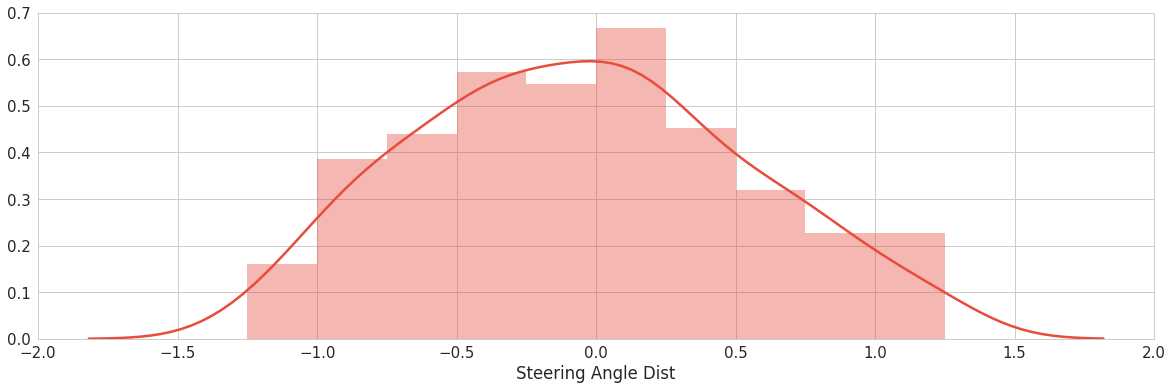

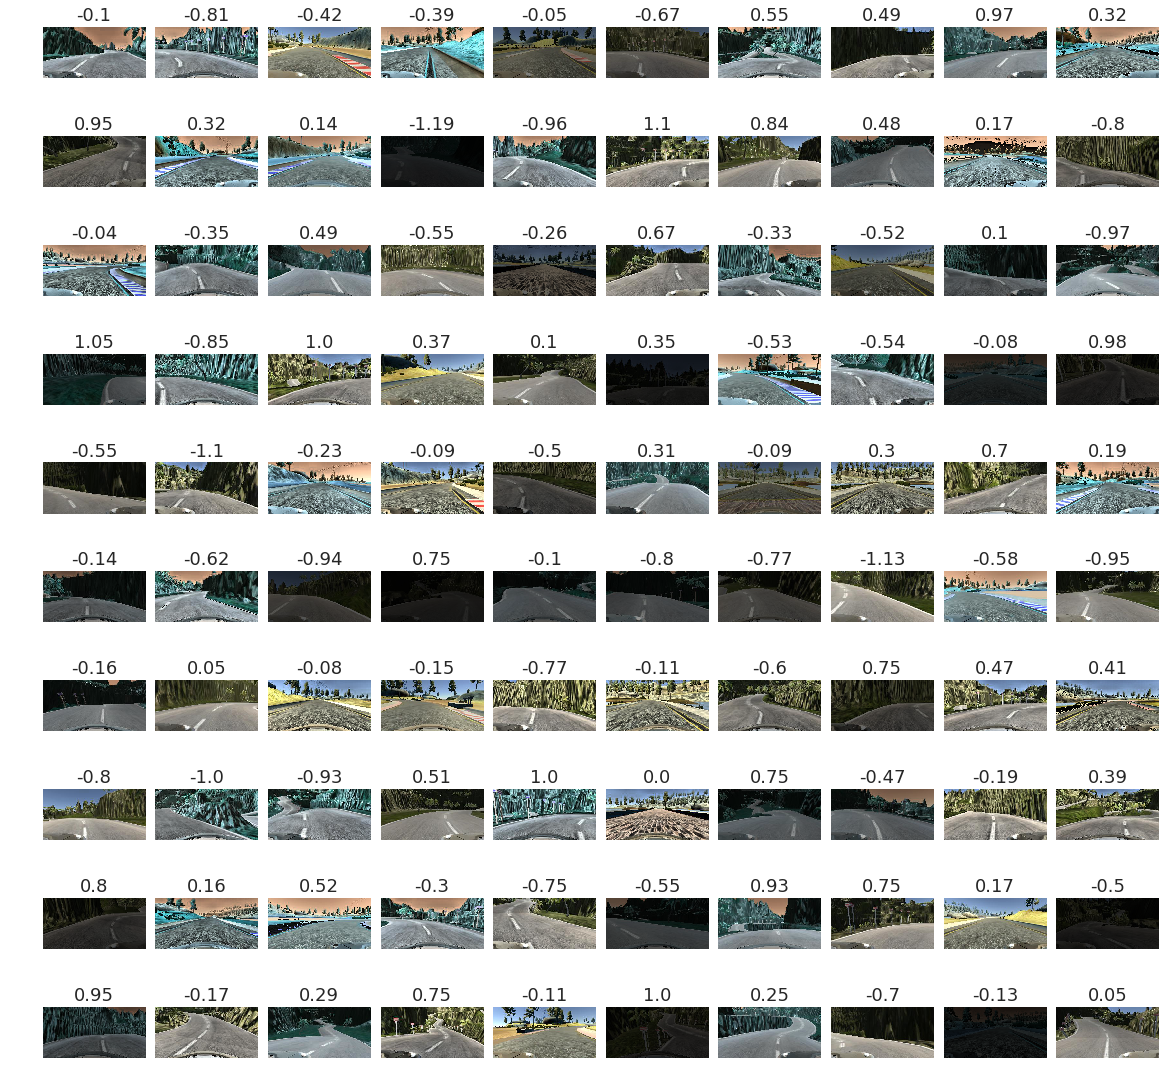

In [12]:
########### Sample evaluation of PreProcessed Images etc . ###############
def create_training_dataset_():
    X_ = []
    Y_ = []

    # Create a Random Normal Sample based on weights from the complete Data Frame
    ####### n = Number of Samples defined by the the batch size ###########
    
    Sample_ = complete_data.sample(
        n=100, weights=complete_data['weights'])
    get_df_data_dist(Sample_)
    for i in range(len(Sample_)):

        # Handles to randomize actions color space perturbation,
        # brightness, histogram equalization and flipping
        flip_coin1 = np.random.randint(0, 2)
        flip_coin2 = np.random.randint(0, 2)
        flip_coin3 = np.random.randint(0, 2)
        flip_coin4 = np.random.randint(0, 2)

        j = np.random.randint(0, 3)
        k = j + 7
        steer_ = Sample_.iloc[i][k]
        image_ = cv2.imread(Sample_.iloc[i][j], 1)

        if flip_coin2 == 0:
            image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
        if flip_coin4 == 0:
            image_ = ahisteq(image_)
        if flip_coin3 == 0:
            image_ = random_brightness(image_)

        if flip_coin1 == 0:
            image_ = cv2.flip(image_, 1)
            steer_ = -1.0 * steer_

        X_.append(image_)
        Y_.append(steer_)
    X = np.array(X_)
    Y = np.array(Y_)

    return X,Y

x,y=create_training_dataset_()
images_show(x,np.around(y,2),10,10,False)

### Image Generators

In [8]:
################### Batch Image Generator Function for model training ####
def create_training_dataset():
    while 1:
        X_ = []
        Y_ = []

        # Create a Random Normal Sample based on weights from the complete Data Frame
        ####### n = Number of Samples defined by the the batch size ###########
        Sample_ = complete_data.sample(
            n=BATCH_SIZE, weights=complete_data['weights'])
        for i in range(len(Sample_)):

            # Handles to randomize actions color space perturbation,
            # brightness, histogram equalization and flipping
            flip_coin1 = np.random.randint(0, 2)
            flip_coin2 = np.random.randint(0, 2)
            flip_coin3 = np.random.randint(0, 2)
            flip_coin4 = np.random.randint(0, 2)

            j = np.random.randint(0, 3)
            k = j + 7
            steer_ = Sample_.iloc[i][k]
            image_ = cv2.imread(Sample_.iloc[i][j], 1)

            if flip_coin2 == 0:
                image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
            if flip_coin4 == 0:
                image_ = ahisteq(image_)
            if flip_coin3 == 0:
                image_ = random_brightness(image_)

            if flip_coin1 == 0:
                image_ = cv2.flip(image_, 1)
                steer_ = -1.0 * steer_

            X_.append(image_)
            Y_.append(steer_)
        X = np.array(X_)
        Y = np.array(Y_)

        yield X, Y


################### Batch Image Generator Function for model validation ##
def create_validation_dataset():
    while 1:
        ValSample_ = complete_data.sample(
            n=BATCH_SIZE, weights=complete_data['weights'])
        X_ = []
        Y_ = []
        for i in range(len(ValSample_)):
            j = 0
            k = j + 7
            image_ = cv2.imread(ValSample_.iloc[i][j])
            image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
            steer_ = ValSample_.iloc[i][k]
            X_.append(image_)
            Y_.append(steer_)

        X = np.array(X_)
        Y = np.array(Y_)

        yield X, Y

### Model Helper Functions 

In [24]:
################ Serialize and Save the Model ####################
def model_save(model_, model_name):
    model_json = model_.to_json()
    with open(model_name + ".json", "w") as json_file:
        json_file.write(model_json)
    model_.save_weights(model_name + ".h5")
    model_.save(model_name + "_full.h5")
    print("Saved Model to Disk")


############### Load the Model #############
def model_load(model_name, isFromCheckpoint_=True):
    json_file = open(model_name + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    if not isFromCheckpoint_:
        loaded_model.load_weights(model_name + ".h5")
    else:
        loaded_model.load_weights(CHECKPOINT_PATH)
    print("Model Loaded ")
    return loaded_model

def resize_image(image):
    # This import is required here otherwise the model cannot be loaded in
    # drive.py
    import tensorflow as tf
    return tf.image.resize_images(image, (66, 200))

### Model Architecture

- The NVIDIA Architecture for end to end deep learning is used. 
- Batch Normalization is implemented after every Conv2D and Dense Layers before activations (ELU)
- Switched from ReLU to ELU after reading this paper-https://arxiv.org/abs/1511.07289 and the NVIDIA implementation
- Dropouts are implemented before the flatten layer and before the output layer with a 50% probability
- Tried by adding multiple dropouts but it did need seem to have an effect on improving validation losses. 

<pre>
<font size="3.5"><em><strong>Layer (type)                 Output Shape              Param #</b></em></font>   
=================================================================
<b>cropping2d_1 (Cropping2D)</b>    (None, 90, 320, 3)        0         
_________________________________________________________________
<b>lambda_1 (Lambda)</b>            (None, 66, 200, 3)        0         
_________________________________________________________________
<b>lambda_2 (Lambda)</b>            (None, 66, 200, 3)        0         
_________________________________________________________________
<b>conv2d_1 (Conv2D)</b>            (None, 31, 98, 24)        1824      
_________________________________________________________________
<b>batch_normalization_1</b> (Batch (None, 31, 98, 24)        96        
_________________________________________________________________
<b>elu_1 (ELU)</b>                  (None, 31, 98, 24)        0         
_________________________________________________________________
<b>conv2d_2 (Conv2D)</b>            (None, 14, 47, 36)        21636     
_________________________________________________________________
<b>batch_normalization_2</b> (Batch (None, 14, 47, 36)        144       
_________________________________________________________________
<b>elu_2 (ELU)</b>                  (None, 14, 47, 36)        0         
_________________________________________________________________
<b>conv2d_3 (Conv2D)</b>            (None, 5, 22, 48)         43248     
_________________________________________________________________
<b>batch_normalization_3</b> (Batch (None, 5, 22, 48)         192       
_________________________________________________________________
<b>elu_3 (ELU)</b>                  (None, 5, 22, 48)         0         
_________________________________________________________________
<b>conv2d_4 (Conv2D)</b>            (None, 3, 20, 64)         27712     
_________________________________________________________________
<b>batch_normalization_4</b> (Batch (None, 3, 20, 64)         256       
_________________________________________________________________
<b>elu_4 (ELU)</b>                  (None, 3, 20, 64)         0         
_________________________________________________________________
<b>conv2d_5 (Conv2D)</b>            (None, 1, 18, 64)         36928     
_________________________________________________________________
<b>batch_normalization_5</b> (Batch (None, 1, 18, 64)         256       
_________________________________________________________________
<b>elu_5 (ELU)</b>                  (None, 1, 18, 64)         0         
_________________________________________________________________
<b>flatten_1 (Flatten)</b>          (None, 1152)              0         
_________________________________________________________________
<b>dropout_1 (Dropout)</b>          (None, 1152)              0         
_________________________________________________________________
<b>dense_1 (Dense)</b>              (None, 1164)              1342092   
_________________________________________________________________
<b>batch_normalization_6</b> (Batch (None, 1164)              4656      
_________________________________________________________________
<b>elu_6 (ELU)</b>                  (None, 1164)              0         
_________________________________________________________________
<b>dense_2 (Dense)</b>              (None, 100)               116500    
_________________________________________________________________
<b>batch_normalization_7</b> (Batch (None, 100)               400       
_________________________________________________________________
<b>elu_7 (ELU)</b>                  (None, 100)               0         
_________________________________________________________________
<b>dense_3 (Dense)</b>              (None, 50)                5050      
_________________________________________________________________
<b>batch_normalization_8</b> (Batch (None, 50)                200       
_________________________________________________________________
<b>elu_8 (ELU)</b>                  (None, 50)                0         
_________________________________________________________________
<b>dense_4 (Dense)</b>              (None, 10)                510       
_________________________________________________________________
<b>batch_normalization_9</b> (Batch (None, 10)                40        
_________________________________________________________________
<b>elu_9 (ELU)</b>                  (None, 10)                0         
_________________________________________________________________
<b>dropout_2 (Dropout)</b>          (None, 10)                0         
_________________________________________________________________
<b>dense_5 (Dense)</b>              (None, 1)                 11        

Total params: 1,601,751
Trainable params: 1,598,631
Non-trainable params: 3,120

</pre>

In [ ]:
# Flags / Hyper Parameters
BATCH_SIZE = 32
TEST_TRAIN_RATIO = 0.2
EPOCHS = 1
MODEL_NAME = "20170522_Model"
UNLABELLED_DATASET = "Data.tar"
DROPOUT_RATE = 0.5
IS_LOADMODEL = True
IS_FROMCHECKPOINT = True
CHECKPOINT_PATH = "./" + MODEL_NAME + "_full.h5"
########################## Generate Training Samples during runtime ######
train_generate = create_training_dataset()
valid_generate = create_validation_dataset()


# Load older model or create new model if required
if IS_LOADMODEL:

    model_ = model_load(MODEL_NAME, IS_FROMCHECKPOINT)
    model_.compile(loss='mse', optimizer=Adam(lr=0.0001))

    checkpoint = ModelCheckpoint(checkpoint_path, verbose=1, monitor='val_loss',
                                 save_best_only=True, save_weights_only=False, mode='auto')
    model_.fit_generator(train_generate, steps_per_epoch=5, epochs=EPOCHS, validation_data=valid_generate,
                         validation_steps=100, callbacks=[checkpoint], max_q_size=1, pickle_safe=True)

    model_save(model_, MODEL_NAME)
    model_.summary()
# Create new model if flag is set
else:
    ##################### Build Model Architecture ###########################
   # Crop 50 pixels from the top of the image and 20 from the bottom
    Model_ = Sequential()
    Model_.add(Cropping2D(data_format="channels_last", cropping=(
        (50, 20), (0, 0)), input_shape=(160, 320, 3)))
    Model_.add(Lambda(resize_image))
    Model_.add(Lambda(lambda x: x / 255 - 0.5))

    ################## Block-1 ########################
    Model_.add(Conv2D(24, (5, 5), kernel_initializer='he_normal', strides=(
        2, 2), padding='valid'))
    Model_.add(BatchNormalization())
    Model_.add(ELU())
    ################# Block-2 ########################
    Model_.add(Conv2D(36, (5, 5), kernel_initializer='he_normal', strides=(
        2, 2), padding='valid'))
    Model_.add(BatchNormalization())
    Model_.add(ELU())
    ################ Block-3 #########################
    Model_.add(Conv2D(48, (5, 5), kernel_initializer='he_normal', strides=(
        2, 2), padding='valid'))
    Model_.add(BatchNormalization())
    Model_.add(ELU())
    ################ Block-4 #########################
    Model_.add(Conv2D(64, (3, 3), kernel_initializer='he_normal', strides=(
        1, 1), padding='valid'))
    Model_.add(BatchNormalization())
    Model_.add(ELU())
    ################ Block-4 #########################
    Model_.add(Conv2D(64, (3, 3), kernel_initializer='he_normal', strides=(
        1, 1), padding='valid'))
    Model_.add(BatchNormalization())
    Model_.add(ELU())
    Model_.add(Flatten())

    ################ End of Feature Extractor ####################
    ############### Start of Fully Connected Layers ##############
    Model_.add(Dropout(DROPOUT_RATE))
    #################### Layer-1 ##################################
    Model_.add(Dense(1164, kernel_initializer='he_normal'))
    Model_.add(BatchNormalization())
    Model_.add(ELU())

    #################### Layer-2 ##################################
    Model_.add(Dense(100, kernel_initializer='he_normal'))
    Model_.add(BatchNormalization())
    Model_.add(ELU())

    #################### Layer-3 ##################################
    Model_.add(Dense(50, kernel_initializer='he_normal'))
    Model_.add(BatchNormalization())
    Model_.add(ELU())

    #################### Layer-4 ##################################
    Model_.add(Dense(10, kernel_initializer='he_normal'))
    Model_.add(BatchNormalization())
    Model_.add(ELU())
    Model_.add(Dropout(DROPOUT_RATE))

    #################### Layer-5 ##################################
    Model_.add(Dense(1))
    Model_.compile(loss='mse', optimizer=Adam(lr=0.0001))
    
    ################### Model Run ##############################
    Model_.fit_generator(train_generate, steps_per_epoch=300, epochs=EPOCHS,
                         validation_data=valid_generate, validation_steps=50)
    model_save(Model_, MODEL_NAME)

In [ ]:
# t = tarfile.open("Smooth_Turns.tar", 'r')
# t.extractall()